# Domain Analysis

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys
sys.path.append("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from collections import defaultdict
import ipaddress
import os.path

import matplotlib
import networkx as nx

matplotlib.rcParams['figure.figsize'] = (9.5, 8)

## Load Full DNS Graph

In [6]:
from netanalysis.analysis.analysis_app import AnalysisApp

app = AnalysisApp(os.path.join(os.getcwd(), "..", "..", "ooni_data"))

IntProgress(value=0, description='Loading')

## Create Domain Graph

In [68]:
domain_app = app.domain_app("vk.com")
print("Graph nodes: %s" % ", ".join(sorted(domain_app.domain_graph.nodes)))
print("Parent domains: %s" % (set(nx.dfs_preorder_nodes(app.dns_graph.reverse(copy=False), domain_app.domain)) - set([domain_app.domain])))

Graph nodes: 185.168.223.0/24, 77.120.3.0/24, 87.240.129.0/24, 87.240.165.0/24, 87.240.182.0/24, 93.170.54.0/24, 95.213.11.0/24, vk.com
Parent domains: set()


## Classify Edges

<IPython.core.display.Javascript object>


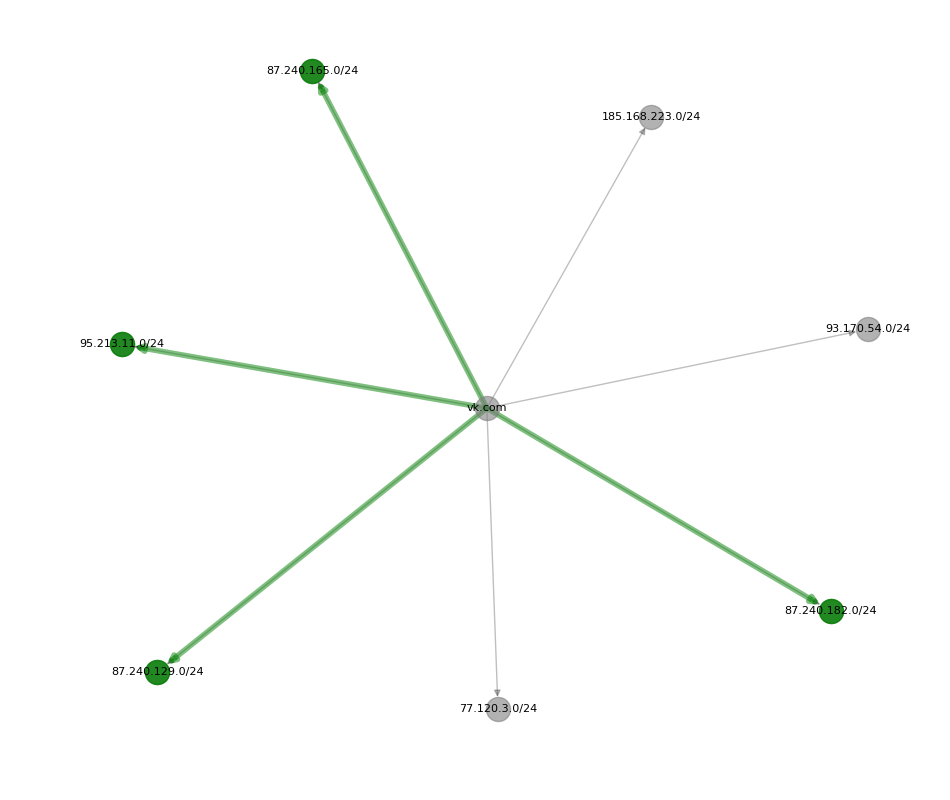

In [69]:
domain_app.display_graph()

## Use TLS to verify UNKNOWNs

At this stage we use TLS validation of certificates to check if an IP is valid for a domain

Checking IPs for vk.com - 185.168.223.0/24
    Validating 185.168.223.254: OSError(113, "Connect call failed ('185.168.223.254', 443)")
Checking IPs for vk.com - 77.120.3.0/24
    Validating 77.120.3.141: SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)')
Checking IPs for vk.com - 93.170.54.0/24
    Validating 93.170.54.239: TimeoutError()


<IPython.core.display.Javascript object>


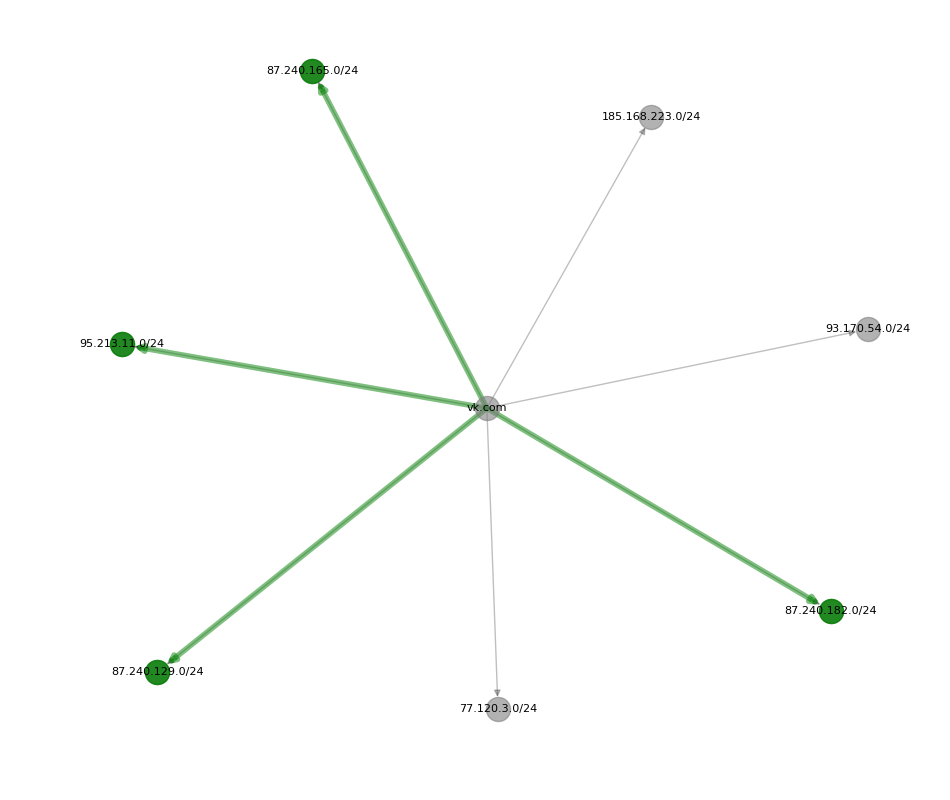

In [70]:
domain_app.tls_verify_unknowns()
domain_app.display_graph()

## Classify Measurements

In [71]:
from netanalysis.dns import classifier as dc

def analyze_measurements(domain: str, domain_graph, class_graph, results=None):
    measurements = dict()  # type: Dict[str, dns.DnsMeasurement]
    for u, v, data in domain_graph.edges(data=True):
        measurement = data.get("measurement")
        if not measurement:
            continue
        if measurement.trust_reason:
            continue
        if measurement.records[0].name.lower() != domain:
            continue
        measurements[measurement.measurement_id] = measurement


    for measurement in sorted(measurements.values(), key=lambda m: m.time):
        measurement_eval = dc.Evaluation(dc.EdgeClass.UNKNOWN, None)
        ips = []
        for record in measurement.records:
            try:
                ip = record.data.ip
                ips.append(ip)
            except AttributeError:
                continue
            
        for ip in ips:
            net = str(ipaddress.ip_network(ip).supernet(new_prefix=24))
            evaluation = class_graph[domain][net]["eval"]
            if evaluation.classification != dc.EdgeClass.UNKNOWN:
                measurement_eval = evaluation
                break
        if not results or measurement_eval.classification in results:
            print("{} {} {}, IPs: [{}] (DNS: {})".format(
                measurement.time,
                measurement.client_country,
                measurement_eval.classification.name,
                ", ".join(str(ip) for ip in ips),
                measurement.resolver_ip
            ))

analyze_measurements(domain_app.domain,
                     domain_app.domain_graph,
                     domain_app.classifier.class_graph,
                     results=[dc.EdgeClass.UNKNOWN, dc.EdgeClass.BAD])

2018-01-28 13:03:57 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-28 13:04:01 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-28 13:04:02 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-28 13:04:05 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-28 13:04:05 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 18:39:21 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 18:39:25 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 18:39:26 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 18:39:30 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 18:39:30 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-29 19:45:32 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-30 21:36:40 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.36)
2018-01-31 11:12:45 UA UNKNOWN, IPs: [77.120.3.141] (DNS: 82.144.192.52)
2018-01-31 11:12:49 UA UNKNOWN, IPs: [77.120.3.141]

## Analyze a country

<IPython.core.display.Javascript object>


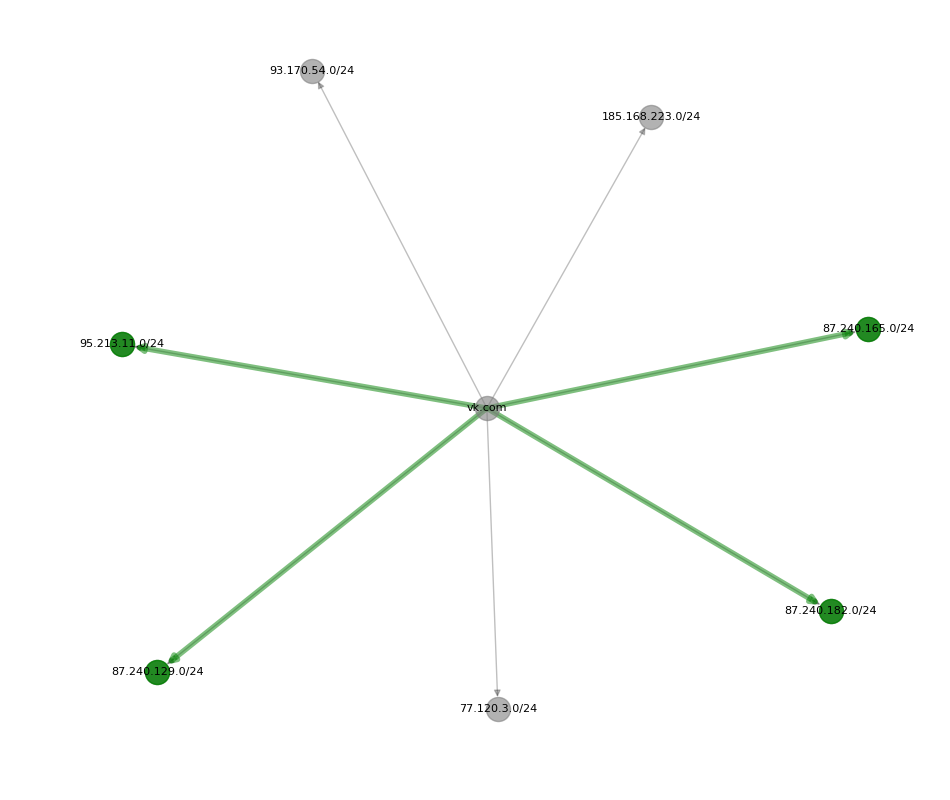

In [76]:
domain_app.display_graph(country="UA")

## Investigate an IP Address

In [73]:
from IPython.display import display
import ipywidgets as widgets
from netanalysis.analysis import ip_info_widget
import netanalysis.analysis.simple_autonomous_system as sas

as_repo = sas.create_default_as_repo()
ip_tab = ip_info_widget.create_ip_info_widget(as_repo)
tabs = widgets.Tab()
tabs.set_title(0, "IP Info")
tabs.children = [ip_tab]
tabs

Tab(children=(VBox(children=(HBox(children=(Text(value='', description='IP', placeholder='Enter ip address'), Button(description='Get info', style=ButtonStyle()))), Output())),), _titles={'0': 'IP Info'})